In [1]:
import adlfs
import fsspec
import xarray as xr

In [25]:
store = fsspec.get_mapper('az://daymet-zarr/daily/hi.zarr', account_name="daymeteuwest")
hi = xr.open_zarr(store, consolidated=True)

store = fsspec.get_mapper('az://daymet-zarr/monthly/pr.zarr', account_name="daymeteuwest")
pr = xr.open_zarr(store, consolidated=True)
pr

'day of year (DOY) starting with day 1 on Januaray 1st'

In [6]:
import cartopy.crs as ccrs

def get_crs(ds):
    lcc = ds.variables["lambert_conformal_conic"].attrs

    prj_kwargs = dict(
        central_latitude=lcc['latitude_of_projection_origin'],
        central_longitude=lcc['longitude_of_central_meridian'],
        standard_parallels=(lcc["standard_parallel"])
    )

    return ccrs.LambertConformal(**prj_kwargs)


def resample_select(ds, var, resample=4, coarsen=1):
    with xr.set_options(keep_attrs=True):
        v = ds[var].sel(time="2019-02-15", method="nearest").coarsen(dim={'x': coarsen, 'y': coarsen}, boundary="trim").mean().compute()
        new_x = np.linspace(ds.x[0], ds.x[-1], ds.dims["x"] * resample)
        new_y = np.linspace(ds.y[0], ds.y[-1], ds.dims["y"] * resample)
        
        return v.interp(x=new_x, y=new_y)

In [15]:
import cartopy
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import cmocean
import numpy as np
import warnings; warnings.simplefilter("ignore")

extent_hi = [-161, -154, 18.5, 22.7]
extent_pr = [-68, -64, 17.25, 19.25]

prj_pr = get_crs(pr)
prj_hi = get_crs(hi)

def get_plotter(ext, prj):
    def pl(da, cmap):
        fig = plt.figure(figsize=(15,8), dpi=200)
        ax = plt.axes(projection=ccrs.PlateCarree(), frameon=False)
        ax.set_extent(ext)
        p = da.plot(ax=ax, transform=prj, cmap=cmap, cbar_kwargs={"aspect": 50}, robust=True)
        ax.add_feature(cartopy.feature.OCEAN, zorder=0)
        ax.set_title(da.name)

    return pl

pr_plot = get_plotter(extent_pr, prj_pr)
hi_plot = get_plotter(extent_hi, prj_hi)

CPU times: user 6.37 s, sys: 286 ms, total: 6.65 s
Wall time: 6.73 s


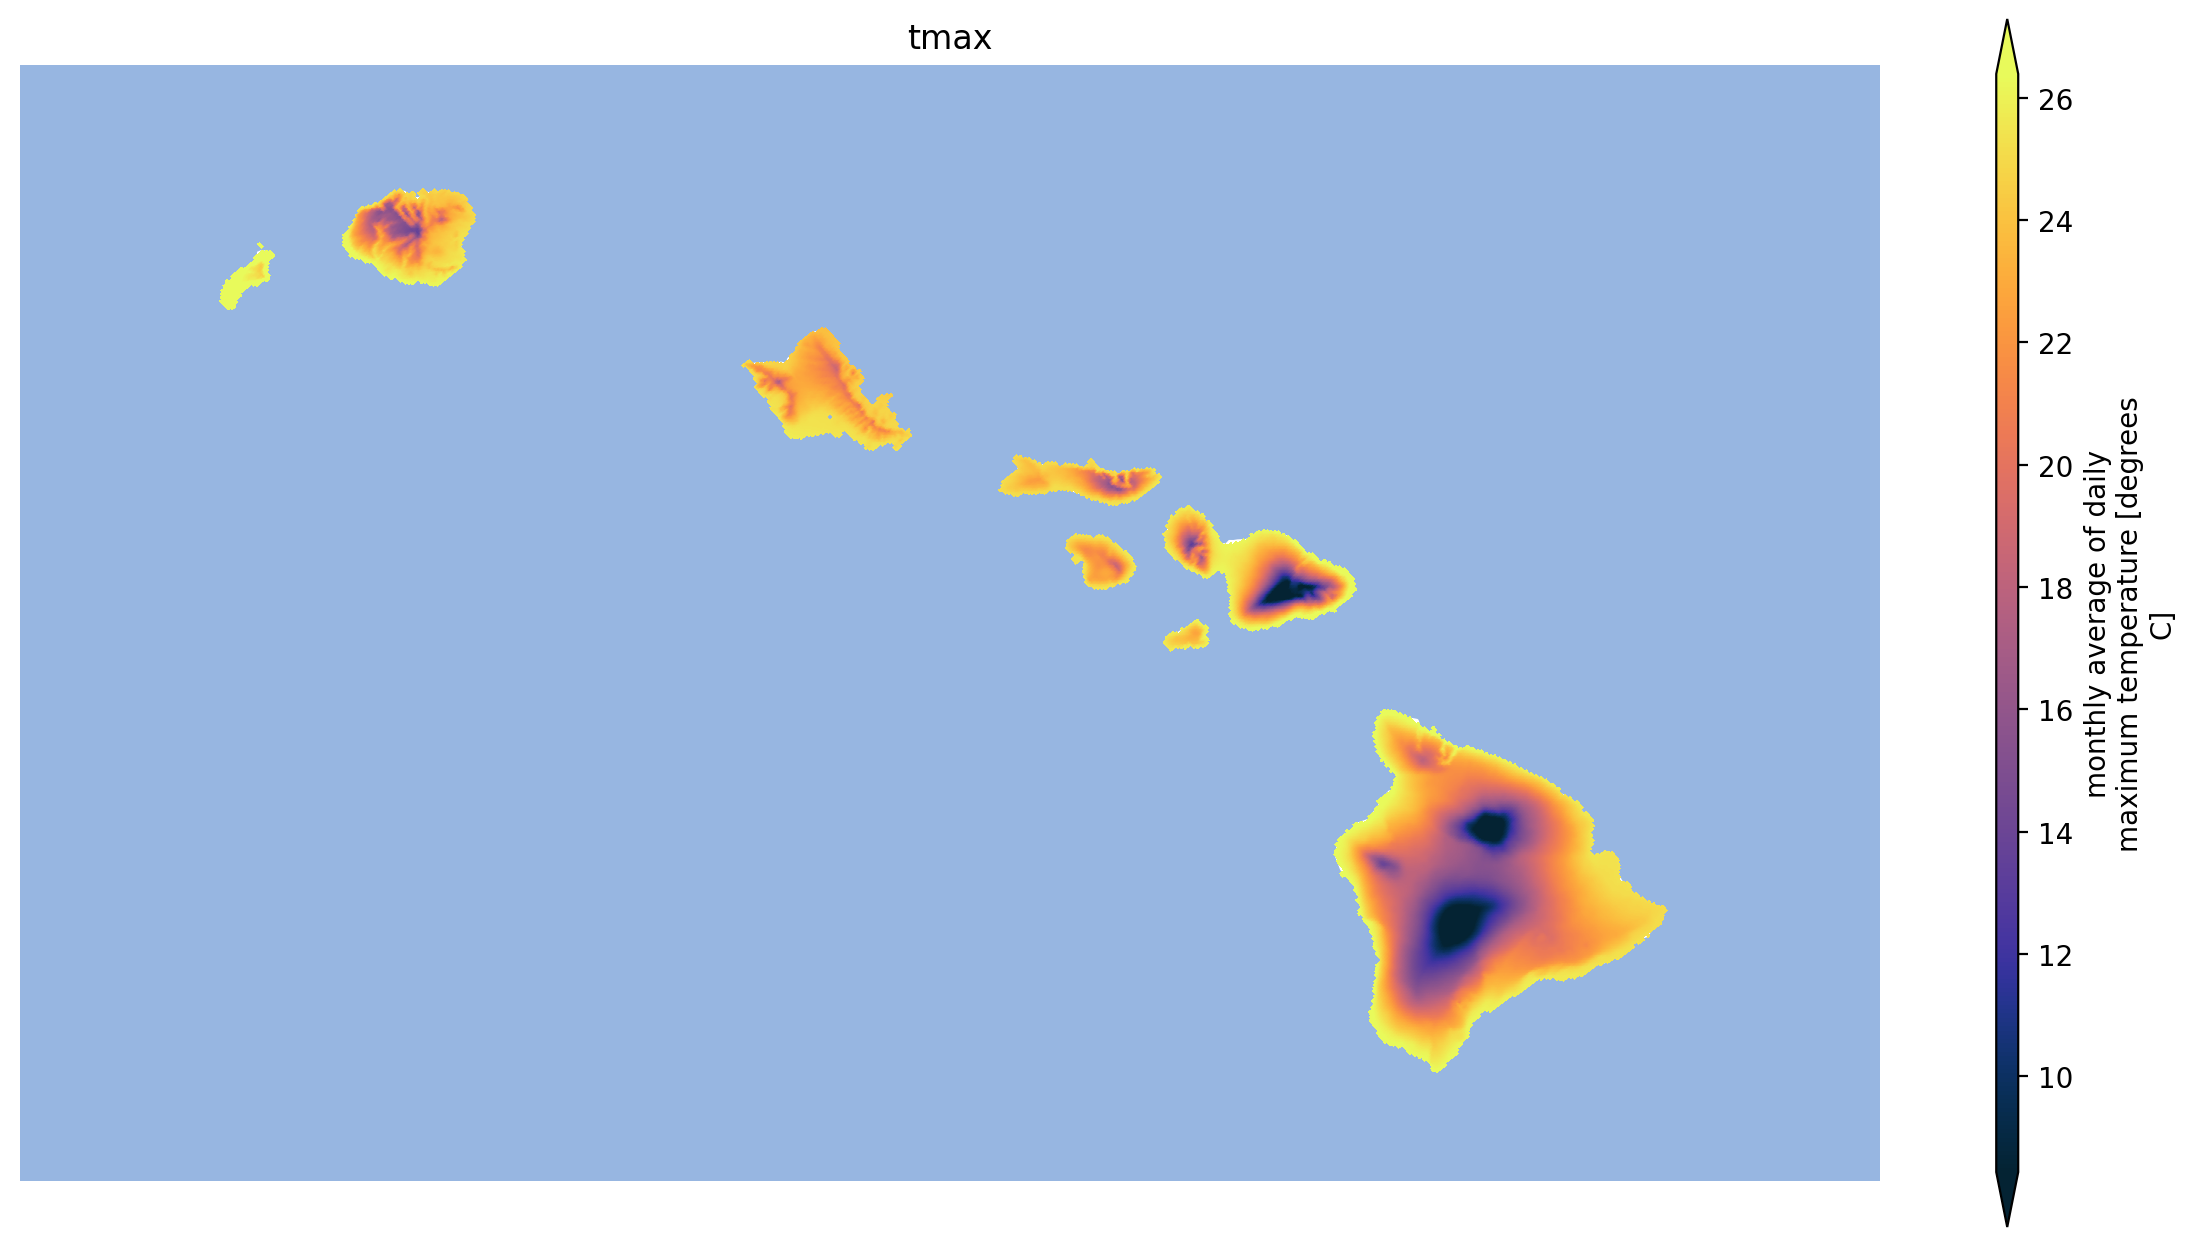

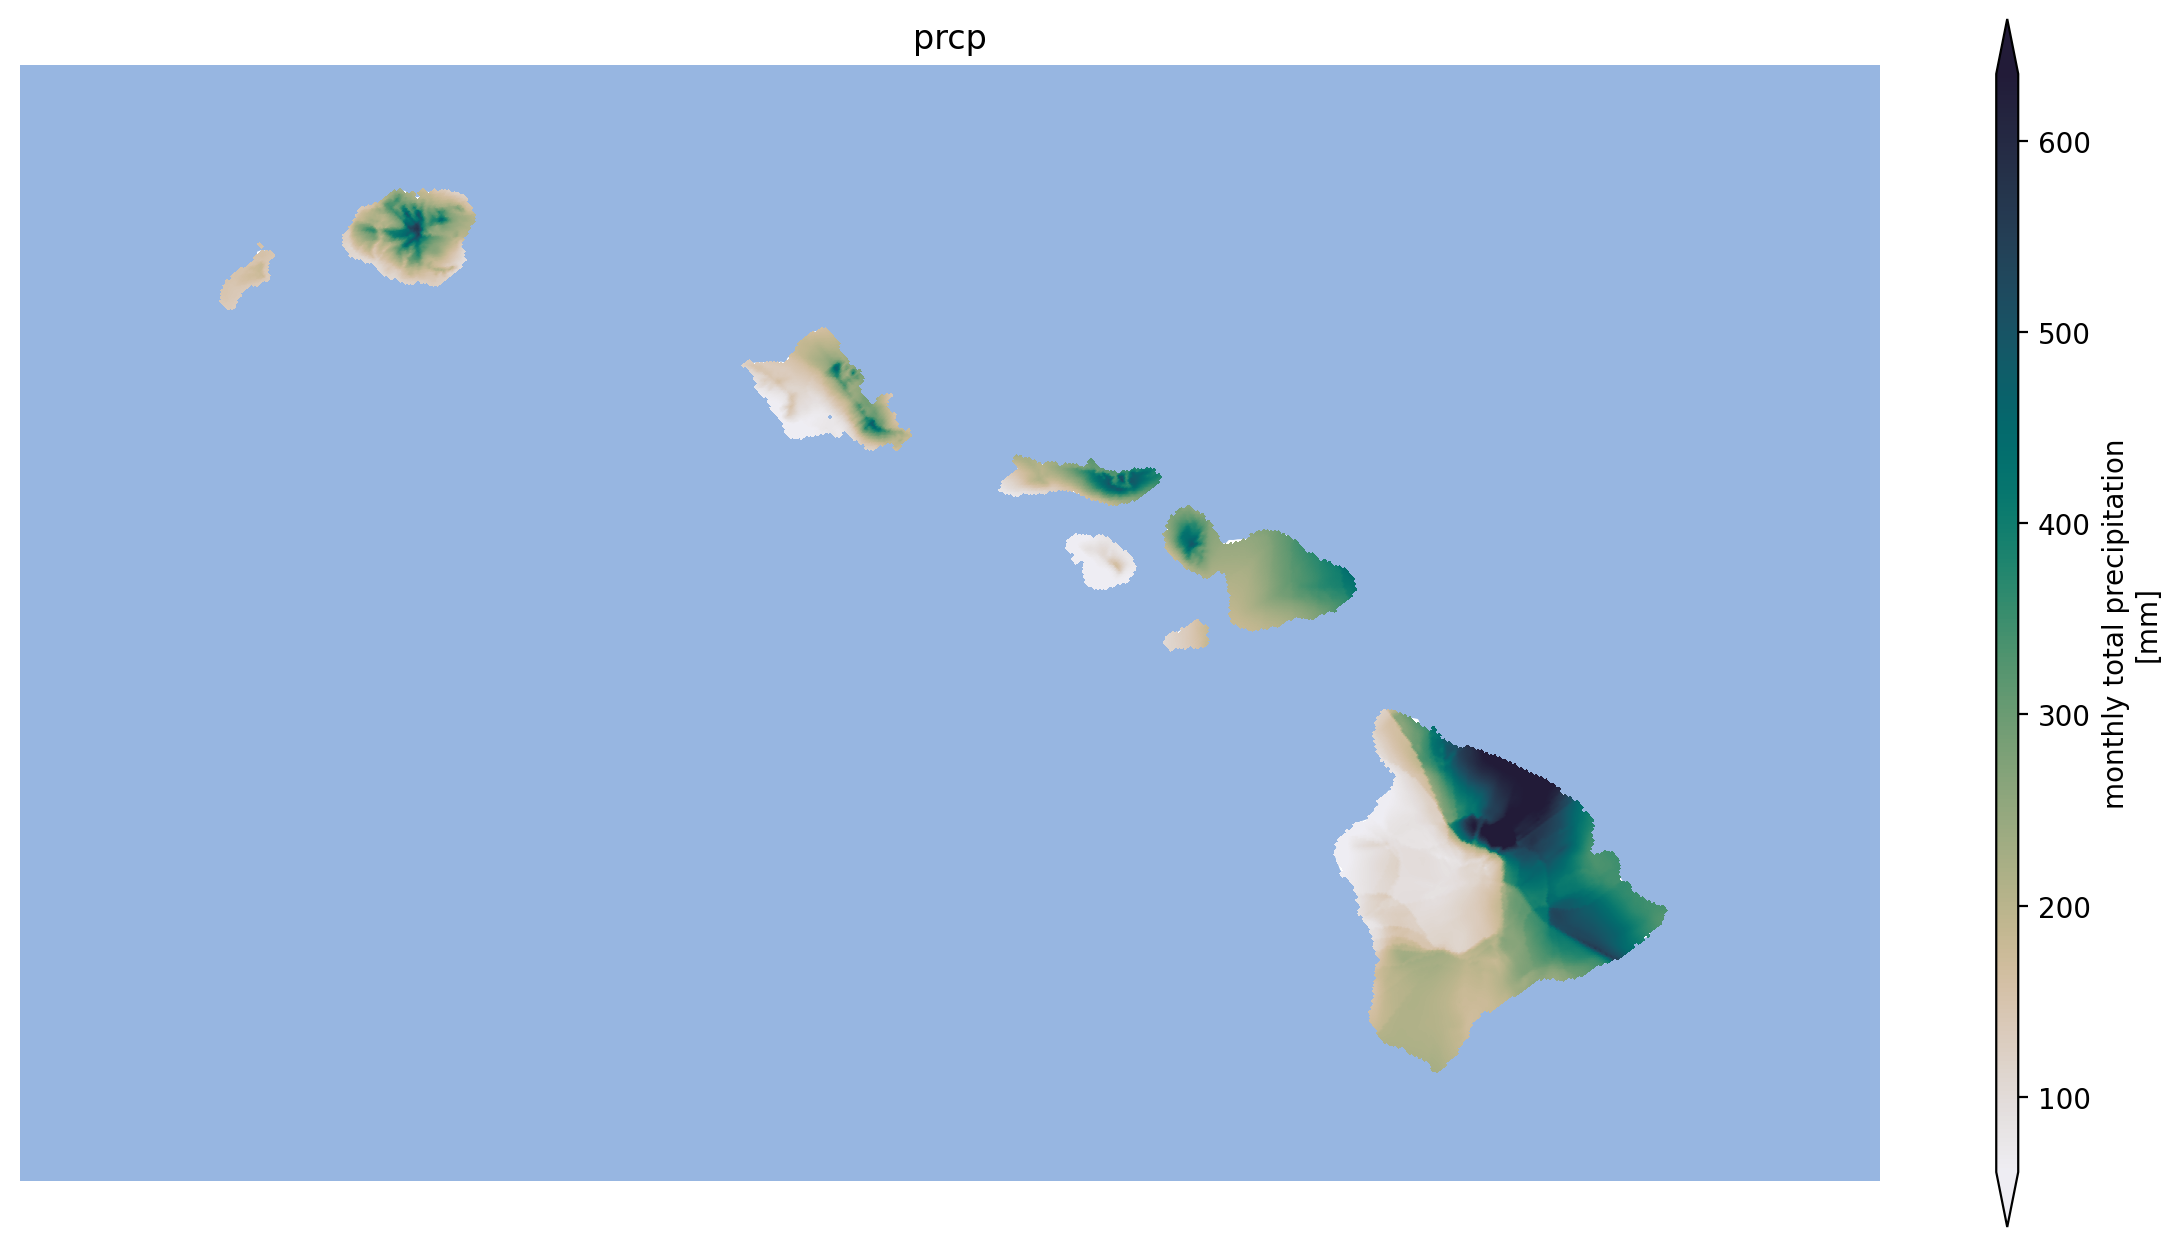

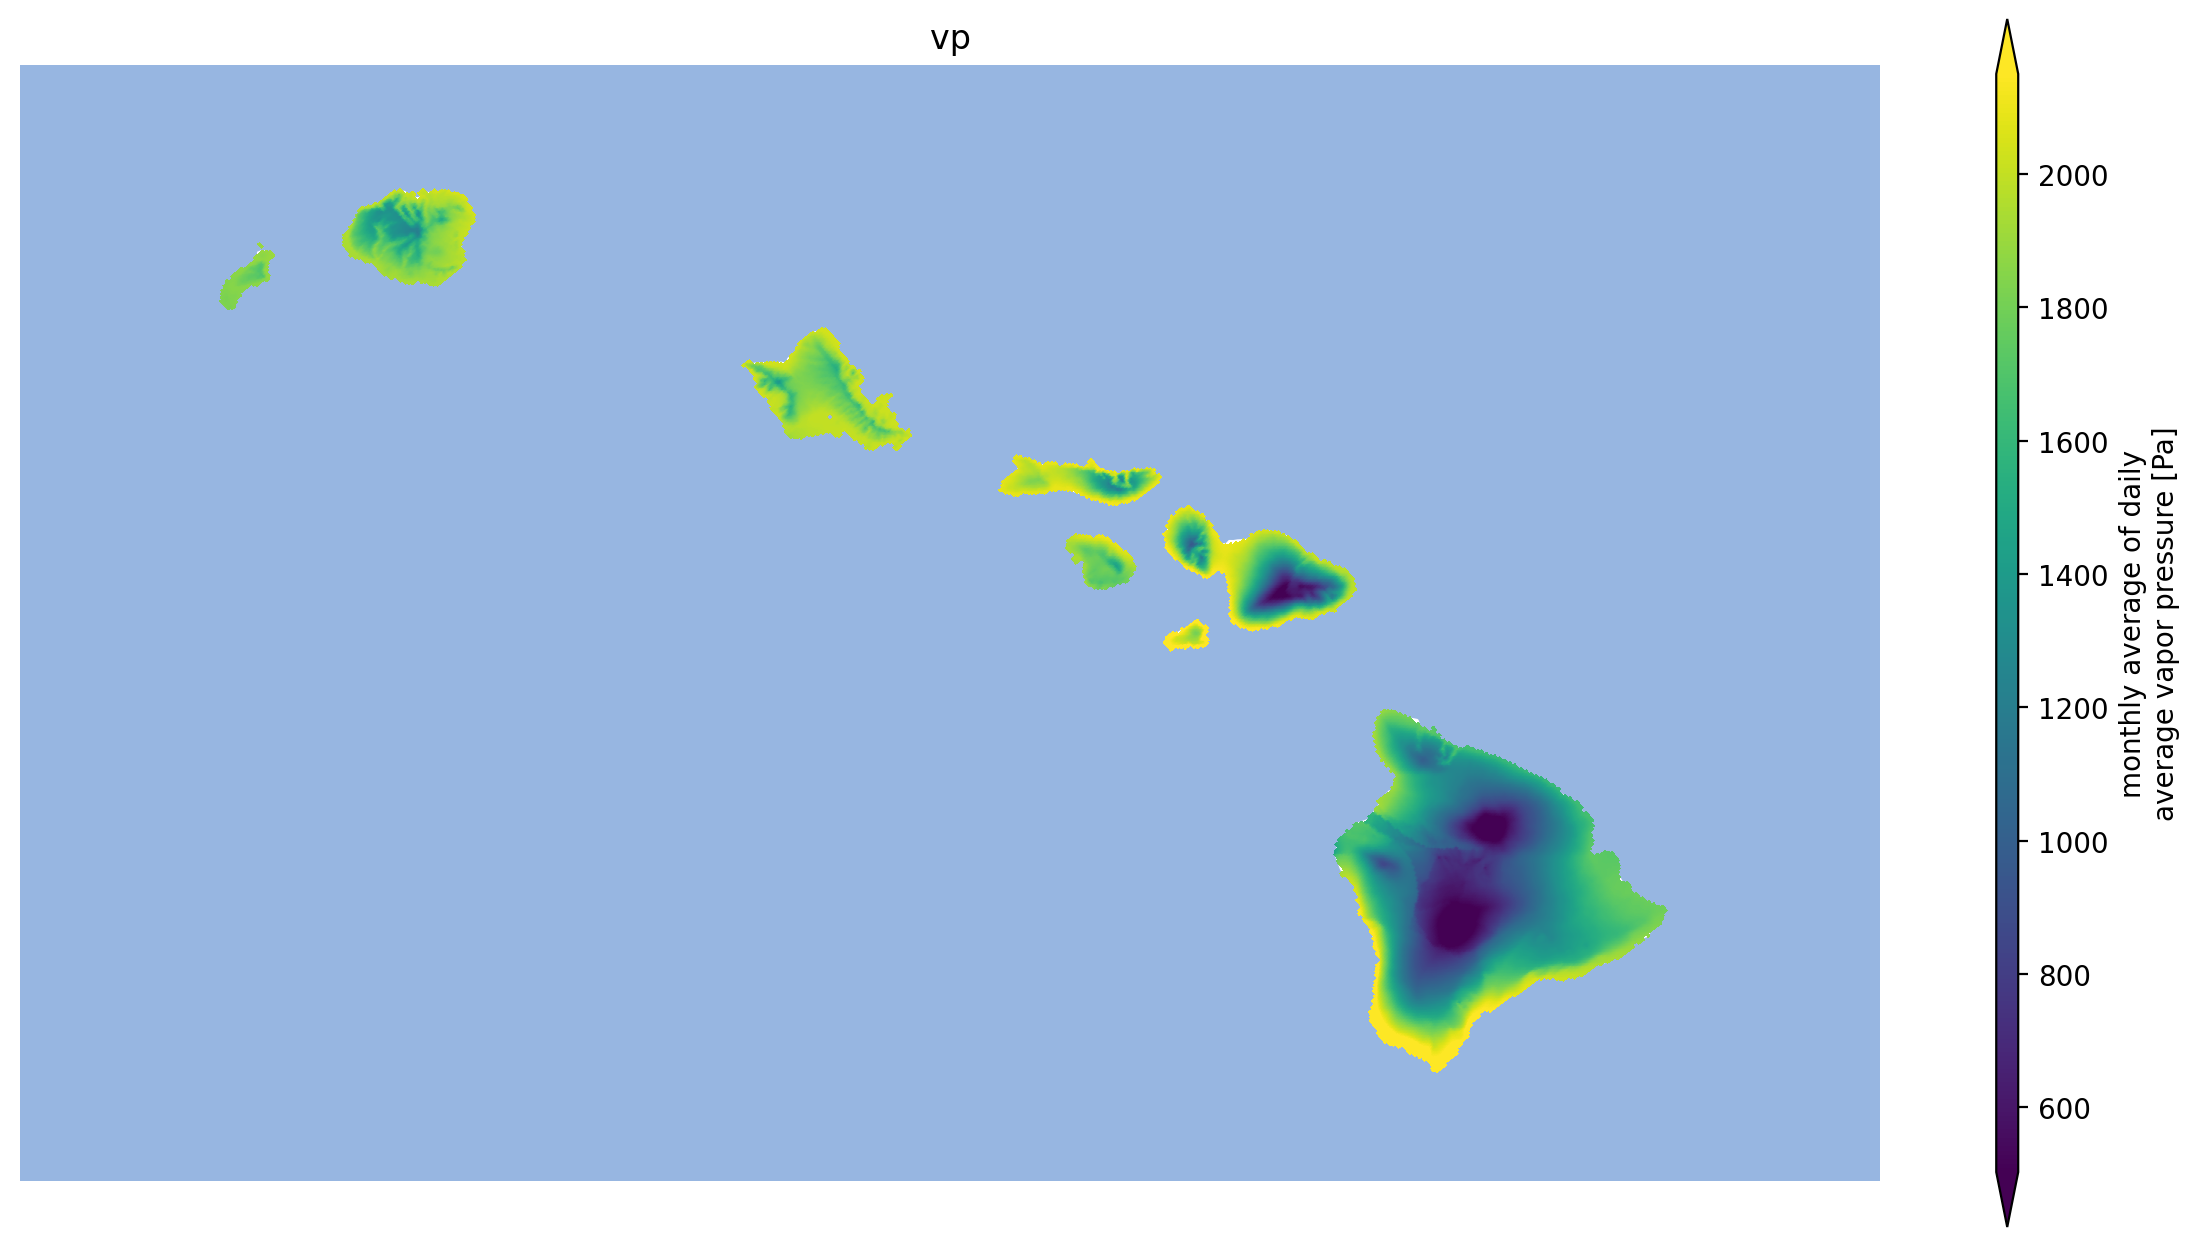

In [16]:
%%time

hi_plot(resample_select(hi, "tmax"), cmocean.cm.thermal)
hi_plot(resample_select(hi, "prcp"), cmocean.cm.rain)
hi_plot(resample_select(hi, "vp"), "viridis")

CPU times: user 3.36 s, sys: 109 ms, total: 3.47 s
Wall time: 3.61 s


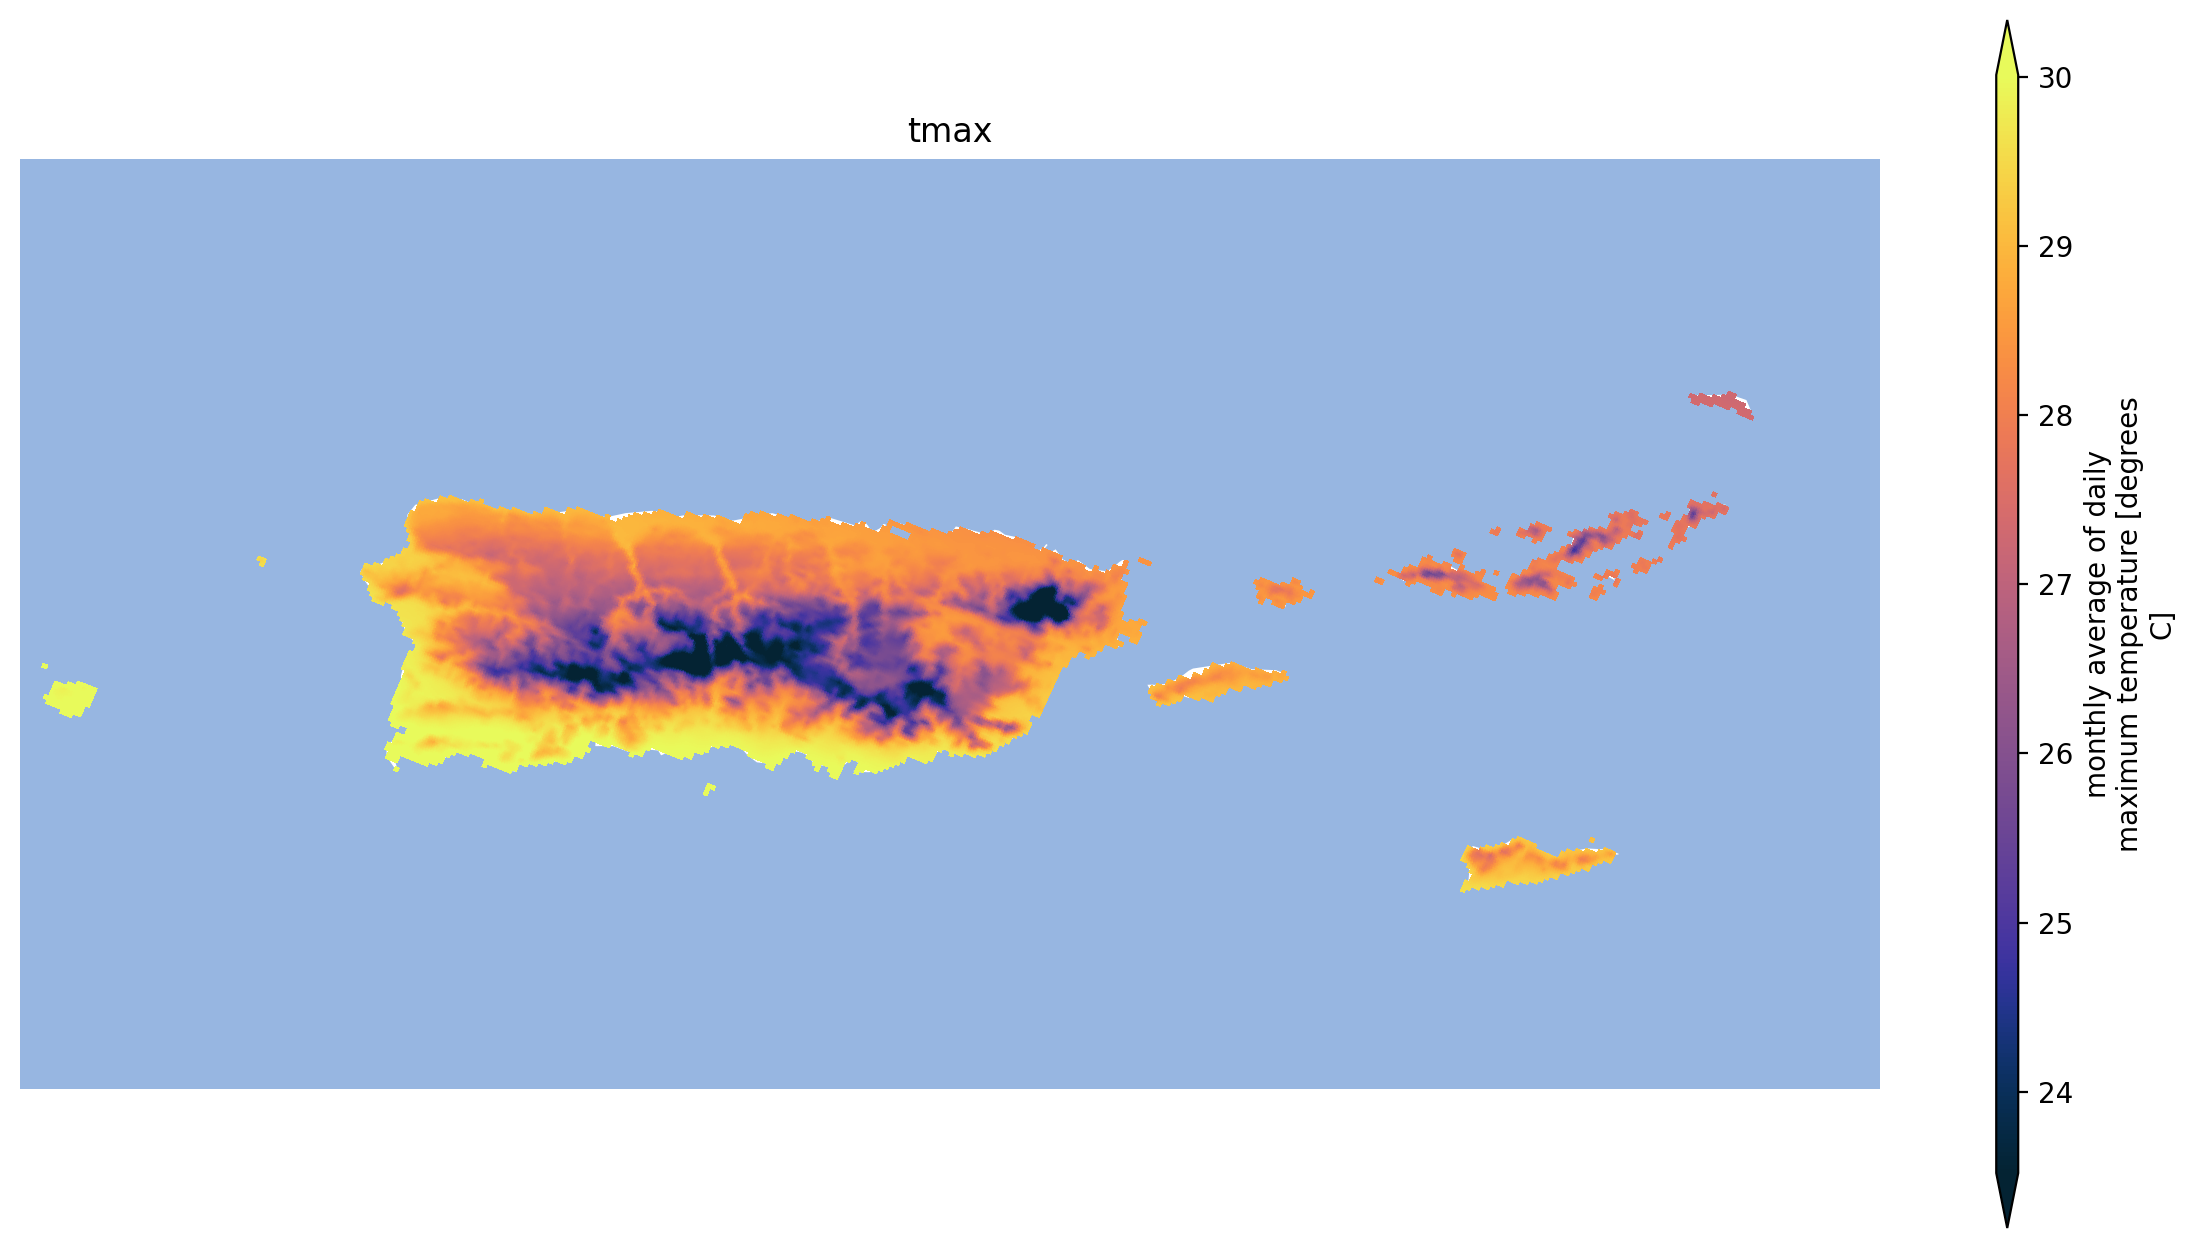

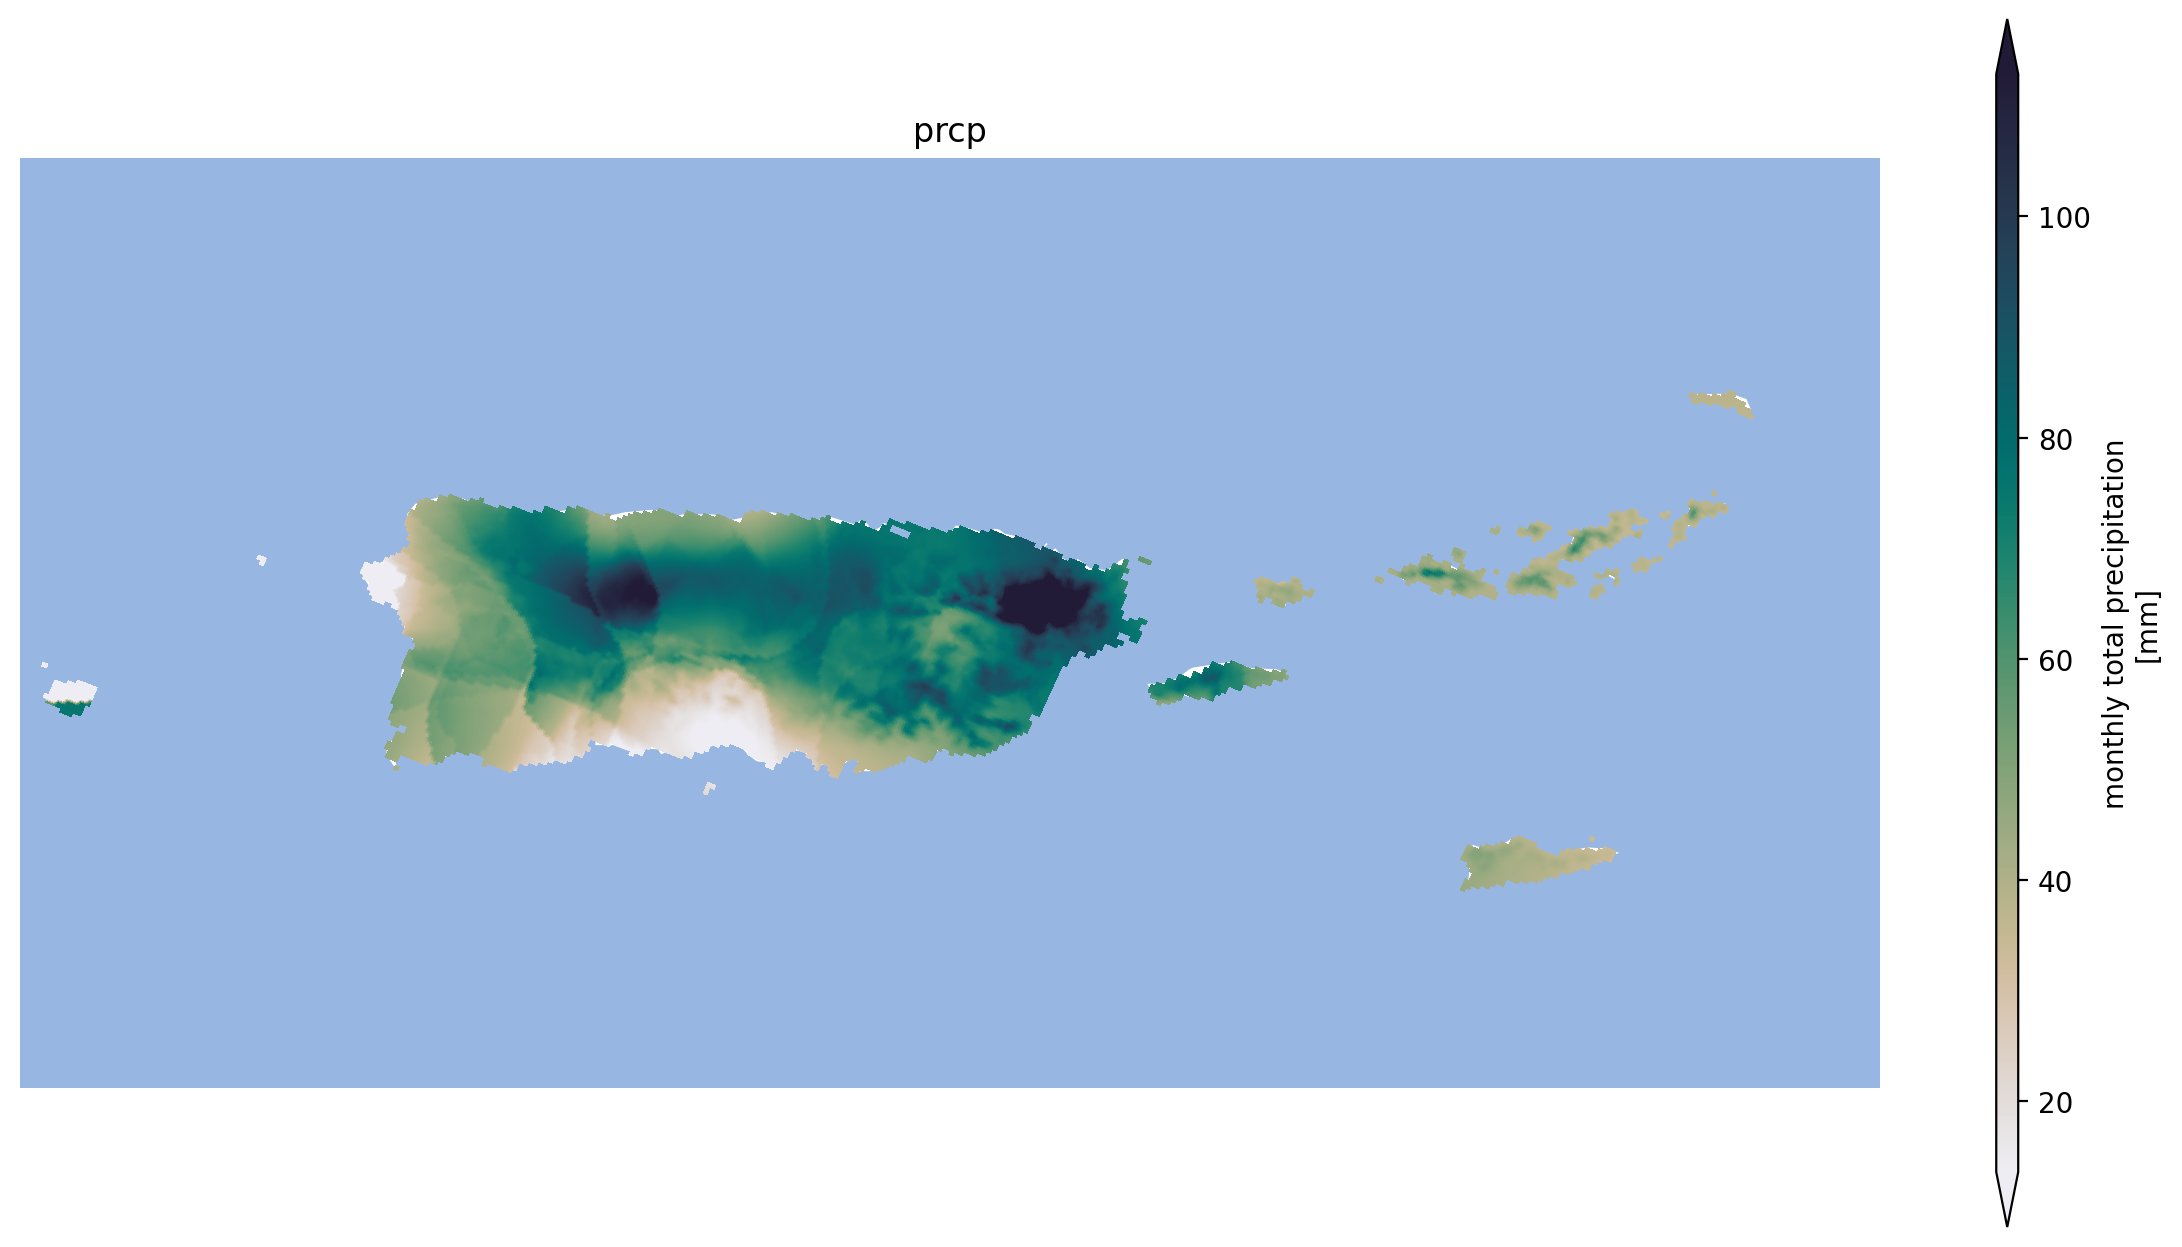

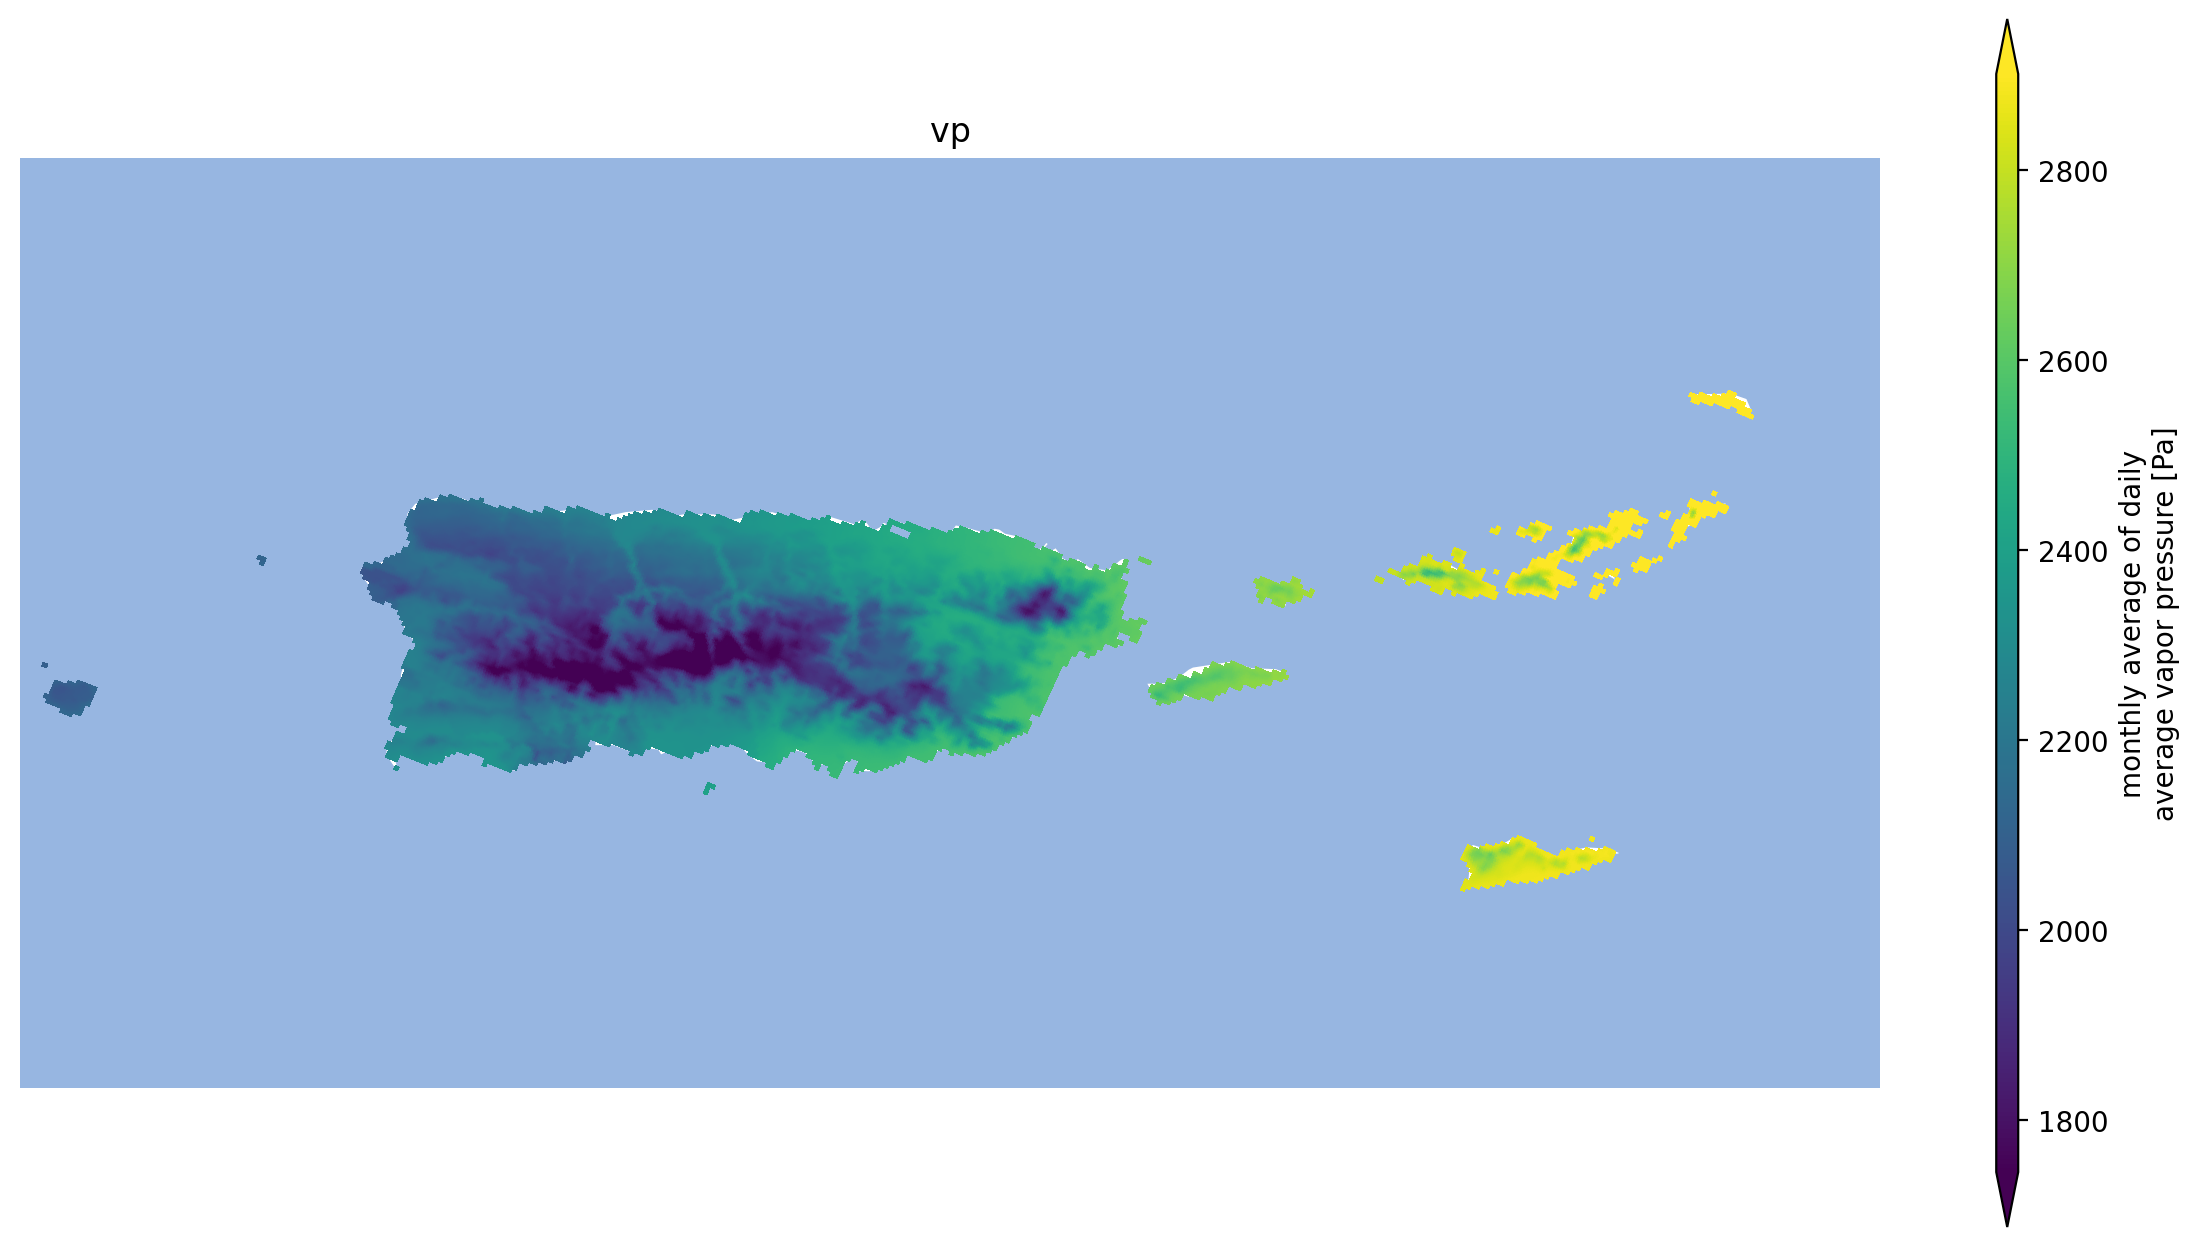

In [18]:
%%time

pr_plot(resample_select(pr, "tmax"), cmocean.cm.thermal)
pr_plot(resample_select(pr, "prcp"), cmocean.cm.rain)
pr_plot(resample_select(pr, "vp"), "viridis")